<a href="https://colab.research.google.com/github/SwarajShinde/Multi-Label-Classification-Bert/blob/master/Sentiment_Machine_Hack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import regex as re


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!pip install transformers

Config :

In [4]:
import transformers
from torch.utils.data import Dataset, DataLoader


In [5]:
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
sub = pd.read_csv('/content/Sample Submission.csv')
train = pd.read_csv("/content/Train.csv")
test = pd.read_csv("/content/Test.csv")

In [7]:
ax = train.loc[:,'Product_Description']

In [8]:
for i in range(5):
    print(ax[i])

The Web DesignerÛªs Guide to iOS (and Android) Apps, today @mention 10 a.m! {link} #sxsw
RT @mention Line for iPad 2 is longer today than yesterday. #SXSW  // are you getting in line again today just for fun?
Crazy that Apple is opening a temporary store in Austin tomorrow to handle the rabid #sxsw eye pad too seekers.
The lesson from Google One Pass: In this digital environment, users want to purchase across every platform with one tool. #sxsw #elonsxsw
RT @mention At the panel: &quot;Your mom has an ipad, designing for boomers&quot; #sxsw


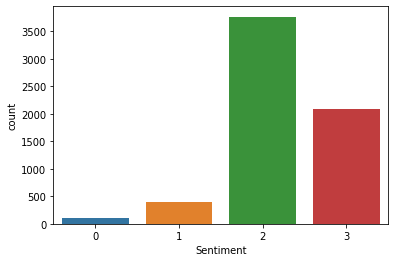

In [9]:
sns.countplot(train['Sentiment'])

Skewed Label Classes 
Startified K-fold for CV

** Text Cleaning Is Required **

Regex Cleaning

In [10]:
import string
def remove_punctuation(text):
    removed_punct = [ word for word in text if word not in string.punctuation]
    final_word = "".join(removed_punct)
    return final_word 


In [11]:
train['review'] = train['Product_Description'].apply(lambda x: remove_punctuation(x))

In [12]:
train.drop('Product_Description',axis=1,inplace=True)

In [13]:
train.head()

,Text_ID,Product_Type,Sentiment,review
0,3057,9,2,The Web DesignerÛªs Guide to iOS and Android ...
1,6254,9,2,RT mention Line for iPad 2 is longer today tha...
2,8212,9,2,Crazy that Apple is opening a temporary store ...
3,4422,9,2,The lesson from Google One Pass In this digita...
4,5526,9,2,RT mention At the panel quotYour mom has an ip...


In [14]:
test['review'] = test['Product_Description'].apply(lambda x: remove_punctuation(x))

In [15]:
train.shape

(6364, 4)

In [16]:
test.drop("Product_Description",axis=1,inplace=True)

In [17]:
train.drop('Text_ID',axis=1,inplace=True)

50


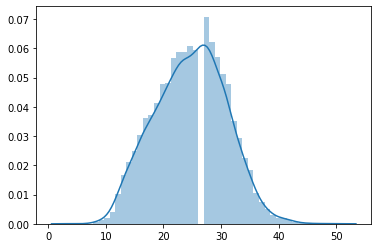

In [21]:
token_lens=[]

for text in train.review:
    tok = tokenizer.encode(text)
    token_lens.append(len(tok))

sns.distplot(token_lens)
print(max(token_lens))

In [19]:
DEVICE = 'cuda'
bert_path = 'bert-base-uncased'
tokenizer = transformers.BertTokenizer.from_pretrained(bert_path,do_lower_case=True)
MAX_LEN = 64
train_batch_size = 8
valid_batch_size = 4


In [22]:
class BertDataset(Dataset):
    def __init__(self,reviews,targets):
        self.reviews=reviews
        self.tokenizer = tokenizer
        self.targets = targets # have a doubt over this 
        self.max_len = MAX_LEN
        
    def __len__(self):
        return len(self.reviews)


    def __getitem__(self,item):
        review = str(self.reviews[item])
      #  review = "".join(review.split())
        inputs = self.tokenizer.encode_plus( 
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation = True
        )
        target = self.targets[item]


        ids =  inputs['input_ids']
        mask = inputs['attention_mask']



        return {
            'review_text':review,
            'ids':inputs['input_ids'].flatten(),
            'mask':inputs['attention_mask'].flatten(),
            'target':torch.tensor(target,dtype=torch.long)
        }

In [23]:
from sklearn.model_selection import train_test_split
df_train,df_valid = train_test_split(train,test_size=0.1,random_state=42,stratify = train['Sentiment'])


In [24]:
df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)

In [25]:
train_dataset = BertDataset(reviews=df_train.review.values,targets=df_train.Sentiment.values)
valid_dataset = BertDataset(reviews=df_valid.review.values,targets=df_valid.Sentiment.values)

train_dataloader = DataLoader(train_dataset,batch_size=train_batch_size,num_workers=4)
valid_dataloader = DataLoader(valid_dataset,batch_size=valid_batch_size,num_workers=1)

In [26]:
# Example Batch :

exam = next(iter(train_dataloader))
exam.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'ids', 'mask', 'target'])

In [27]:
print(exam['ids'].shape)
print(exam['mask'].shape)
print(exam['target'].shape)

torch.Size([8, 64])
torch.Size([8, 64])
torch.Size([8])


Now till here we can infer that our DataLoader/Dataset is working FINE ....

In [53]:
class BertModel(nn.Module):
    def __init__(self):
        super(BertModel,self).__init__()
        self.bert = transformers.BertModel.from_pretrained(bert_path)
        self.drop = nn.Dropout(0.1)
        self.out = nn.Linear(768,4)
        
    def forward(self,ids,mask):
        _,o2 = self.bert(ids,attention_mask=mask)
        bo = self.drop(o2)
        output = self.out(bo)
        return output

In [54]:
model = BertModel()

In [55]:
model = model.to(DEVICE)

Move all to GPU



1.   LEARN TO USE TQDM




In [32]:
# EXAMPLE :
ids = exam['ids'].to(DEVICE)
mask = exam['mask'].to(DEVICE)
print(ids.shape)

torch.Size([8, 64])


In [95]:
x= (model(ids,mask))
#print(model(ids,mask))
print(x)
#print(x.shape)
torch.max(x,dim=1
          )

tensor([[-1.0419, -2.3395,  3.8415, -0.5955],
        [-0.8687, -2.5651, -0.9116,  5.2733],
        [-1.8754, -3.9308,  3.6802,  1.7517],
        [-1.9340, -3.8975,  3.8293,  2.0463],
        [-1.9291, -3.8285,  3.4014,  1.8849],
        [-0.9461, -2.6454, -0.9023,  5.0187],
        [-1.8419, -3.9053,  4.2601,  1.6035],
        [ 0.2037,  0.8619,  1.5382, -3.4882]], device='cuda:0',
       grad_fn=<AddmmBackward>)


torch.return_types.max(values=tensor([3.8415, 5.2733, 3.6802, 3.8293, 3.4014, 5.0187, 4.2601, 1.5382],
       device='cuda:0', grad_fn=<MaxBackward0>), indices=tensor([2, 3, 2, 2, 2, 3, 2, 2], device='cuda:0'))

In [56]:
loss_fn = nn.CrossEntropyLoss().to(DEVICE)
epochs = 5
optimizer =  AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)


In [57]:
def train_fn(data_loader,model,optimizer,loss_fn,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0
    tkt = tqdm(data_loader,total = len(data_loader))
    for d in tkt:
        ids = d['ids'].to(device)
        mask = d['mask'].to(device)
        targets = d['target'].to(device)

        outputs = model(ids=ids,mask=mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds==targets)
        losses.append(loss.item())
    
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    #print(f"Individual Training Losses {loss.item()} " )
    return correct_predictions.double() / n_examples, np.mean(losses)



In [58]:
def eval_fn(data_loader,model,device,loss_fn,n_examples):
    model = model.eval()
    losses= []
    correct_predictions = 0
    with torch.no_grad():
        tke = tqdm(data_loader,total = len(data_loader))
        for d in tke:
            ids = d['ids'].to(device)
            mask = d['mask'].to(device)
            targets = d['target'].to(device)

            outputs = model(ids=ids,mask=mask)
            _,preds = torch.max(outputs,dim=1)

            loss = loss_fn(outputs,targets)


            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
           # print(f"Individual Evaluation Losses {loss.item()} " )

    return correct_predictions.double() / n_examples, np.mean(losses)



In [59]:
from sklearn import metrics
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

In [60]:
from collections import defaultdict

Now the Almighty Training Loop

In [61]:
def run():

    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1} /{epochs}")
        print('-' * 10)
        

        train_acc,train_loss = train_fn(train_dataloader,model,optimizer,loss_fn,DEVICE,scheduler,len(df_train))
        
        print(f"Training Losses {train_loss} accuracy {train_acc}")
        

        eval_acc,eval_loss = eval_fn(valid_dataloader,model,DEVICE,loss_fn,len(df_valid))

        print(f'Val loss {eval_loss} accuracy {eval_acc}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['eval_acc'].append(eval_acc)
        history['eval_loss'].append(eval_loss)

        if eval_acc > best_accuracy:
            torch.save(model.state_dict(), 'best_model_state.bin')
            best_accuracy = eval_acc


In [62]:
run()

  0%|          | 0/716 [00:00<?, ?it/s]

Epoch 1 /5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Losses 0.8602318079861183 accuracy 0.6245852977125894


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 160/160 [00:02<00:00, 66.46it/s]


Val loss 0.8016556500457227 accuracy 0.6248037676609105



  0%|          | 0/716 [00:00<?, ?it/s]

Epoch 2 /5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Losses 0.6260975821973891 accuracy 0.753448576916361


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 160/160 [00:02<00:00, 66.56it/s]


Val loss 0.8070500325877219 accuracy 0.6624803767660911



  0%|          | 0/716 [00:00<?, ?it/s]

Epoch 3 /5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Losses 0.41157614385615515 accuracy 0.8505325650427797


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 160/160 [00:02<00:00, 65.67it/s]


Val loss 0.9261689843609929 accuracy 0.6640502354788069



  0%|          | 0/716 [00:00<?, ?it/s]

Epoch 4 /5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Losses 0.28854329029472764 accuracy 0.8990745591059891


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
  0%|          | 0/716 [00:00<?, ?it/s]

Val loss 1.0703456054790876 accuracy 0.6483516483516484

Epoch 5 /5
----------


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

Training Losses 0.2144544015654139 accuracy 0.9280600663523659


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 160/160 [00:02<00:00, 66.18it/s]

Val loss 1.1595388233603443 accuracy 0.6624803767660911



In [ ]:
# Time to perform Inference

In [ ]:
submission = pd.Dataframe

In [39]:
'''
from google.colab import drive
drive.mount("/content/drive")
'''

'\nfrom google.colab import drive\ndrive.mount("/content/drive")\n'

In [ ]:
/content/best_model_state.bin

In [63]:
test.head()

,Text_ID,Product_Type,review
0,5786,7,RT mention Going to SXSW The new iPhone guide ...
1,5363,9,RT mention 95 of iPhone and Droid apps have le...
2,6716,9,RT mention Thank you to mention for letting me...
3,4339,7,Thanks mention were lovin the mention app upda...
4,66,9,At sxsw mention mention wanna buy you a drink...


** Inference **

In [80]:
class BertDataset_test(Dataset):
    def __init__(self,reviews):
        self.reviews=reviews
        self.tokenizer = tokenizer
        self.max_len = MAX_LEN
        
    def __len__(self):
        return len(self.reviews)


    def __getitem__(self,item):
        review = str(self.reviews[item])
        inputs = self.tokenizer.encode_plus( 
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation = True
        )


        ids =  inputs['input_ids']
        mask = inputs['attention_mask']



        return {
            'review_text':review,
            'ids':inputs['input_ids'].flatten(),
            'mask':inputs['attention_mask'].flatten()
        }

In [81]:
test_df = BertDataset_test(test.review.values)

In [82]:
test_dataloader = DataLoader(test_df,batch_size=4,num_workers=2)

In [83]:
# Checking Whether the Bottleneck is Dataloader or the trainnig Loop itself


In [84]:
example = next(iter(test_dataloader))
example.keys()

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input si

dict_keys(['review_text', 'ids', 'mask'])

In [85]:
print(example['ids'].shape)
print(example['ids'].shape)
print(example['mask'].shape)


torch.Size([4, 64])
torch.Size([4, 64])
torch.Size([4, 64])


In [86]:
ex_ids = example['ids'].to(DEVICE)
ex_mask = example['mask'].to(DEVICE)

In [89]:
y = F.softmax(model(ex_ids,ex_mask),dim=1)

In [88]:
print(y)
torch.max(y,axis=1)

tensor([[1.4041e-03, 2.4591e-04, 2.8603e-03, 9.9549e-01],
        [4.6622e-02, 9.4327e-01, 8.6560e-03, 1.4546e-03],
        [5.7570e-03, 1.6359e-03, 9.8272e-01, 9.8836e-03],
        [3.0183e-03, 5.6878e-04, 1.5976e-01, 8.3666e-01]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


torch.return_types.max(values=tensor([0.9955, 0.9433, 0.9827, 0.8367], device='cuda:0',
       grad_fn=<MaxBackward0>), indices=tensor([3, 1, 2, 3], device='cuda:0'))

In [63]:
# So here we confirm that out dataLoader is not our Bottle neck

In [114]:
#torch.save(model.state_dict(), '/content/drive/My Drive/best_model_state.bin')


In [65]:
model = model.to(DEVICE)

In [90]:
# Hope so the weights loaded are the weights of the best model
from tqdm import tqdm

In [ ]:
# Create Testing Loop 
test["sentiment"] = 0

In [99]:
def test_fn(model,dataloader,device,):
    model.eval()
    final_pred = []
    with torch.no_grad():
        tk0 = tqdm(test_dataloader,total=len(test_dataloader))
        for data in tk0:
            ids = data['ids'].to(device)
            mask = data['mask'].to(device)
            op = model(ids,mask)
            _,preds = torch.max(op,dim=1)
            # if want the probability dont use max()
            final_pred.append(preds.tolist())

    return final_pred

    

In [100]:
axes = test_fn(model,test_dataloader,DEVICE)



  0%|          | 0/682 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_leng

In [112]:
print("Pre-Processing of the outputs to generate the submision")

Pre-Processing of the outputs to generate the submision


In [101]:
print(axes)


[[3, 1, 2, 3], [2, 2, 2, 3], [3, 2, 3, 3], [1, 3, 2, 2], [2, 1, 1, 2], [2, 2, 3, 3], [3, 2, 2, 3], [3, 3, 2, 2], [2, 2, 1, 3], [3, 1, 3, 3], [2, 3, 2, 2], [2, 2, 3, 2], [3, 2, 1, 2], [2, 3, 2, 2], [2, 2, 2, 2], [2, 2, 3, 2], [3, 2, 2, 3], [2, 2, 2, 3], [2, 2, 2, 2], [2, 2, 1, 2], [2, 2, 1, 2], [1, 3, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 3], [3, 2, 2, 3], [3, 2, 3, 3], [3, 2, 3, 3], [2, 2, 1, 3], [2, 2, 3, 2], [2, 2, 2, 1], [2, 2, 2, 1], [2, 3, 2, 3], [1, 1, 2, 1], [3, 2, 3, 3], [2, 2, 2, 3], [2, 2, 3, 2], [2, 2, 1, 2], [2, 2, 2, 1], [1, 2, 2, 2], [3, 3, 2, 3], [2, 2, 2, 2], [2, 2, 2, 2], [2, 3, 2, 3], [2, 2, 3, 2], [3, 2, 2, 2], [2, 3, 3, 2], [2, 2, 2, 1], [2, 3, 2, 3], [2, 3, 3, 2], [3, 2, 1, 2], [2, 1, 3, 3], [2, 1, 2, 2], [2, 3, 2, 3], [3, 3, 2, 2], [2, 2, 1, 2], [2, 2, 2, 2], [3, 2, 3, 2], [2, 2, 2, 3], [3, 2, 2, 2], [3, 2, 3, 3], [2, 2, 2, 2], [2, 3, 2, 2], [2, 3, 2, 2], [2, 2, 3, 2], [2, 3, 2, 2], [2, 3, 2, 2], [2, 3, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2, 2, 2], [2, 2

In [108]:
# aha this seems some Good predictions as compared to the previous predictions where the model predicted class2 always
# We are going to fill in the Classes for the test Dataframe , if want you can use the probablities

In [102]:
senti = []
for i in axes:
    senti.extend(i)
print(senti)

[3, 1, 2, 3, 2, 2, 2, 3, 3, 2, 3, 3, 1, 3, 2, 2, 2, 1, 1, 2, 2, 2, 3, 3, 3, 2, 2, 3, 3, 3, 2, 2, 2, 2, 1, 3, 3, 1, 3, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2, 1, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 2, 3, 3, 2, 3, 3, 3, 2, 3, 3, 2, 2, 1, 3, 2, 2, 3, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 3, 2, 3, 1, 1, 2, 1, 3, 2, 3, 3, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 2, 2, 2, 3, 3, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 2, 1, 2, 3, 2, 3, 2, 3, 3, 2, 3, 2, 1, 2, 2, 1, 3, 3, 2, 1, 2, 2, 2, 3, 2, 3, 3, 3, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 2, 3, 3, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 3, 3, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 1, 3, 2, 3, 3, 2, 3, 2, 2, 2, 2, 3, 3, 2, 1, 2, 2, 2, 3, 3, 2, 2, 2, 2, 2, 

In [106]:
df = pd.DataFrame(senti) 


In [110]:
test["sentiment"] = df

In [111]:
test.head()

,Text_ID,Product_Type,review,sentiment
0,5786,7,RT mention Going to SXSW The new iPhone guide ...,3
1,5363,9,RT mention 95 of iPhone and Droid apps have le...,1
2,6716,9,RT mention Thank you to mention for letting me...,2
3,4339,7,Thanks mention were lovin the mention app upda...,3
4,66,9,At sxsw mention mention wanna buy you a drink...,2


In [114]:
test.drop("Product_Type",axis=1,inplace=True)
test.to_csv('submission1.csv') 


In [115]:
test_pred = pd.read_csv("/content/submission1.csv")

In [116]:
test_pred.head(10)

,Unnamed: 0,Text_ID,review,sentiment
0,0,5786,RT mention Going to SXSW The new iPhone guide ...,3
1,1,5363,RT mention 95 of iPhone and Droid apps have le...,1
2,2,6716,RT mention Thank you to mention for letting me...,2
3,3,4339,Thanks mention were lovin the mention app upda...,3
4,4,66,At sxsw mention mention wanna buy you a drink...,2
5,5,8373,I just rated GSDampM Idea City LLC 5 stars men...,2
6,6,4264,mention Making new fans and friends I hope RT ...,2
7,7,1982,Want a chance to win an iPad 2 while youre at ...,3
8,8,2258,mention be sure to use our FREE App for checki...,3
9,9,8828,Free SXSW music sampler on itunes Includes men...,2


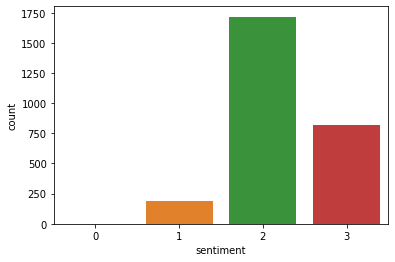

In [118]:
sns.countplot(test_pred["sentiment"])